# Enefit - Predict Energy Behavior of Prosumers

The challenge in this competition is to predict the amount of electricity produced and consumed by Estonian energy customers who have installed solar panels. The dataset includes weather data, the relevant energy prices, and records of the installed photovoltaic capacity.

This is a forecasting competition using the time series API.

**Description**

The number of prosumers is rapidly increasing, and solving the problems of energy imbalance and their rising costs is vital. If left unaddressed, this could lead to increased operational costs, potential grid instability, and inefficient use of energy resources. If this problem were effectively solved, it would significantly reduce the imbalance costs, improve the reliability of the grid, and make the integration of prosumers into the energy system more efficient and sustainable. Moreover, it could potentially incentivize more consumers to become prosumers, knowing that their energy behavior can be adequately managed, thus promoting renewable energy production and use.

**About us**

Enefit is one of the biggest energy companies in Baltic region. As experts in the field of energy, we help customers plan their green journey in a personal and flexible manner as well as implement it by using environmentally friendly energy solutions.
At present, Enefit is attempting to solve the imbalance problem by developing internal predictive models and relying on third-party forecasts. However, these methods have proven to be insufficient due to their low accuracy in forecasting the energy behavior of prosumers. The shortcomings of these current methods lie in their inability to accurately account for the wide range of variables that influence prosumer behavior, leading to high imbalance costs. By opening up the challenge to the world's best data scientists through the Kaggle platform, Enefit aims to leverage a broader pool of expertise and novel approaches to improve the accuracy of these predictions and consequently reduce the imbalance and associated costs.

**Evaluation**

Submissions are evaluated on the Mean Absolute Error (MAE) between the predicted return and the observed target. The formula is given by:

𝑀𝐴𝐸=1𝑛∑𝑖=1𝑛|𝑦𝑖−𝑥𝑖|

Where:
* 𝑛 is the total number of data points.
* 𝑦𝑖 is the predicted value for data point i.
* 𝑥𝑖 is the observed value for data point i.

**Submitting**

You must submit to this competition using the provided python time-series API, which ensures that models do not peek forward in time. To use the API, follow the template in this [notebook](https://www.kaggle.com/code/sohier/enefit-basic-submission-demo).

**Timeline**

This is a future data prediction competition with an active training phase and a second period where selected submissions will be evaluated against future ground truth data.

*Training Timeline*

* November 1, 2023 - Start Date.
* January 24, 2024 - Entry Deadline. You must accept the competition rules before this date in order to compete.
* January 24, 2024 - Team Merger Deadline. This is the last day participants may join or merge teams.
* January 31, 2024 - Final Submission Deadline.

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

*Prediction Timeline:*

Starting after the final submission deadline there will be periodic updates to the leaderboard to reflect future data updates that will be evaluated against selected submissions. We anticipate 1-3 interim updates before the final evaluation.

* April 30, 2024 - Competition End Date

**Prizes**

* 1st Place - $ 15,000
* 2nd Place - $ 10,000
* 3rd Place - $ 8,000
* 4th Place - $ 7,000
* 5th Place - $ 5,000
* 6th Place - $ 5,000

**Code Requirements**

Submissions to this competition must be made through Notebooks. In order for the "Submit" button to be active after a commit, the following conditions must be met:

* CPU Notebook <= 9 hours run-time
* GPU Notebook <= 9 hours run-time
* Internet access disabled
* Freely & publicly available external data is allowed, including pre-trained models
* Submission file must be named submission.csv and be generated by the API.

Please see the [Code Competition FAQ](https://www.kaggle.com/docs/competitions#notebooks-only-FAQ) for more information on how to submit. And review the [code debugging doc](https://www.kaggle.com/code-competition-debugging) if you are encountering submission errors.

### Load Workspace

In [50]:
import re
import datetime as dt
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
import seaborn as sns
import opendatasets as od
import kaggle
import zipfile
import io
import json
import warnings
import ipywidgets as widgets

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import notebook
from itertools import product
from typing import Union
from scipy.signal import periodogram

from sklearn.linear_model import LogisticRegression, LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, classification_report, mean_squared_error

### Load the Dataset

In [3]:
def list_files_in_zip(zip_file_path):
    zip_files = list()
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        for file in file_list:
            zip_files.append(file)
    return zip_files

zip_file_path = 'predict-energy-behavior-of-prosumers.zip'

enefit_files = list_files_in_zip(zip_file_path)
enefit_files

['client.csv',
 'county_id_to_name_map.json',
 'electricity_prices.csv',
 'enefit/__init__.py',
 'enefit/competition.cpython-310-x86_64-linux-gnu.so',
 'example_test_files/client.csv',
 'example_test_files/electricity_prices.csv',
 'example_test_files/forecast_weather.csv',
 'example_test_files/gas_prices.csv',
 'example_test_files/historical_weather.csv',
 'example_test_files/revealed_targets.csv',
 'example_test_files/sample_submission.csv',
 'example_test_files/test.csv',
 'forecast_weather.csv',
 'gas_prices.csv',
 'historical_weather.csv',
 'public_timeseries_testing_util.py',
 'train.csv',
 'weather_station_to_county_mapping.csv']

In [4]:
def read_csv_from_zip(zip_file_path, csv_file_name):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        with zip_ref.open(csv_file_name) as file:
            df = pd.read_csv(io.TextIOWrapper(file))
            return df

def read_json_from_zip(zip_file_path, json_file_name):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        with zip_ref.open(json_file_name) as file:
            data = json.load(file)
            df = pd.DataFrame(data, index=range(len(data)))
            return df

In [5]:
enefit_dict = dict()
keys = [
    'client', 'county_id_to_name_map',
    'electricity_prices', 'forecast_weather',
    'gas_prices', 'historical_weather',
    'train', 'weather_station_to_county_mapping'
]

In [6]:
for key in keys:
    if key + '.csv' in enefit_files:
        csv_file_name = key + '.csv'
        enefit_dict[key] = read_csv_from_zip(zip_file_path, csv_file_name)
    elif key + '.json' in enefit_files:
        json_file_name = key + '.json'
        enefit_dict[key] = read_json_from_zip(zip_file_path, json_file_name)
    

In [7]:
enefit_dict.keys()

dict_keys(['client', 'county_id_to_name_map', 'electricity_prices', 'forecast_weather', 'gas_prices', 'historical_weather', 'train', 'weather_station_to_county_mapping'])

In [8]:
enefit_dict['client'] = enefit_dict['client'].assign(
    date=lambda x: pd.to_datetime(x.date)
)

enefit_dict['county_id_to_name_map'] = enefit_dict['county_id_to_name_map'].iloc[0].T

enefit_dict['electricity_prices'] = enefit_dict['electricity_prices'].assign(
    forecast_date=lambda x: pd.to_datetime(x.forecast_date),
    origin_date=lambda x: pd.to_datetime(x.origin_date),
)

enefit_dict['forecast_weather'] = enefit_dict['forecast_weather'].assign(
    origin_datetime=lambda x: pd.to_datetime(x.origin_datetime),
    forecast_datetime=lambda x: pd.to_datetime(x.forecast_datetime),
)

enefit_dict['gas_prices'] = enefit_dict['gas_prices'].assign(
    forecast_date=lambda x: pd.to_datetime(x.forecast_date),
    origin_date=lambda x: pd.to_datetime(x.origin_date),
)

enefit_dict['historical_weather'] = enefit_dict['historical_weather'].assign(
    datetime=lambda x: pd.to_datetime(x.datetime)
)

enefit_dict['train'] = enefit_dict['train'].assign(
    datetime=lambda x: pd.to_datetime(x.datetime)
)

In [9]:
deep_colors = [
    '#4C72B0', '#55A868', '#C44E52',
    '#8172B2', '#CCB974', '#64B5CD'
]

### Machine Learning

**Client**

The features in this dataset are:
* product_type: ID code with the following mapping of codes to contract types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}
* county: An ID code for the county. See county_id_to_name_map.json for the mapping of ID codes to county names.
* eic_count: The aggregated number of consumption points (EICs - European Identifier Code).
* installed_capacity: Installed photovoltaic solar panel capacity in kilowatts.
* is_business: Boolean for whether or not the prosumer is a business.
* date
* data_block_id: All rows sharing the same `data_block_id` will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather `data_block_id` for predictions made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.

We'll attempt to forecast installed capacity and eic_count to determine which models work best in predicting these variables.

In [10]:
enefit_dict['client'].head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [11]:
enefit_dict['client'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41919 entries, 0 to 41918
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   product_type        41919 non-null  int64         
 1   county              41919 non-null  int64         
 2   eic_count           41919 non-null  int64         
 3   installed_capacity  41919 non-null  float64       
 4   is_business         41919 non-null  int64         
 5   date                41919 non-null  datetime64[ns]
 6   data_block_id       41919 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 2.2 MB


There are 61-69 records for every date in the dataset.

In [12]:
enefit_dict['client'].groupby(by='date').agg({'product_type':'count'}).head()

,product_type
date,
2021-09-01,61
2021-09-02,61
2021-09-03,61
2021-09-04,61
2021-09-05,61


We'll resample the dataset to aggregate all installed incapacity in every date and reduce the dataset to daily records only.

In [13]:
df = enefit_dict['client'].set_index("date").installed_capacity.resample('D').sum().to_period()
df.name = df.name.strip()
df = df.to_frame()
df.head()

,installed_capacity
date,
2021-09-01,70659.26
2021-09-02,70659.26
2021-09-03,70659.26
2021-09-04,70659.26
2021-09-05,70651.26


**Linear Regression with Time Series**

There are two kinds of features unique to time series: time-step features and lag features.

Time-step features are features we can derive directly from the time index. The most basic time-step feature is the *time dummy*, which counts off time steps in the series from beginning to end. The time dummy then lets us fit curves to time series in a *time plot*, where `Time` forms the x-axis. Time-step features let you model **time dependence**. A series is time dependent if its values can be predicted from the time they occured.

To make a **lag feature** we shift the observations of the target series so that they appear to have occured later in time. Lag features let us fit curves to *lag plots* where each observation in a series is plotted against the previous observation. Lag features let you model **serial dependence**. A time series has serial dependence when an observation can be predicted from previous observations.

In [14]:
df['time'] = np.arange(len(df.index))
df['lag_1'] = df.installed_capacity.shift(1)
df = df.reindex(columns=['installed_capacity', 'time', 'lag_1'])

df.head()

,installed_capacity,time,lag_1
date,,,
2021-09-01,70659.26,0,NaN
2021-09-02,70659.26,1,70659.26
2021-09-03,70659.26,2,70659.26
2021-09-04,70659.26,3,70659.26
2021-09-05,70651.26,4,70659.26


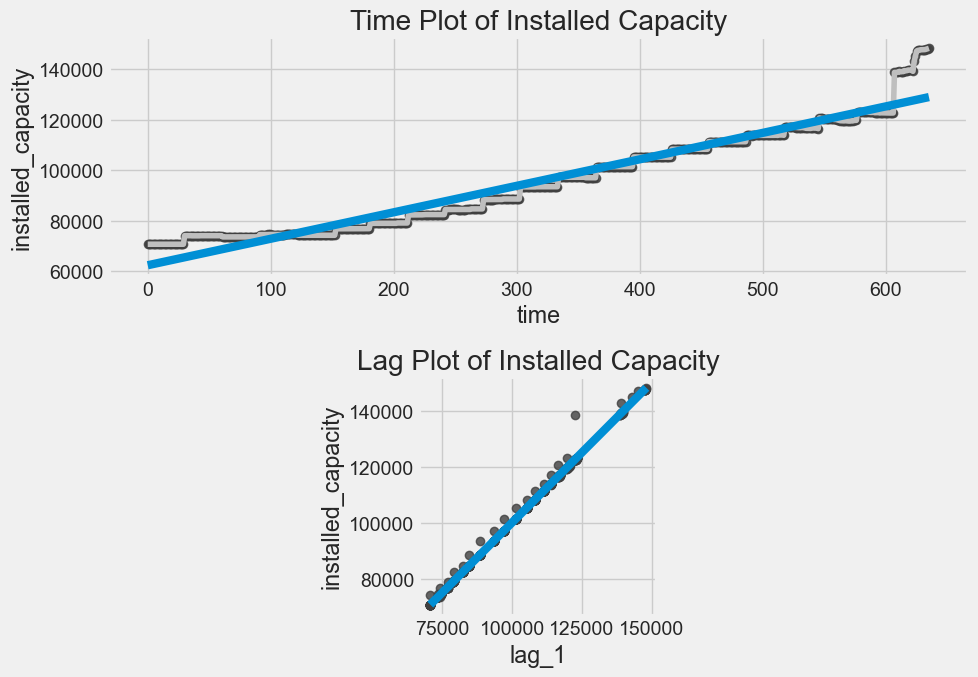

In [15]:
# plt.style.use("seaborn-v0_8-whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

ax1.plot('time', 'installed_capacity', data=df, color='0.75')
sns.regplot(
    x='time', y='installed_capacity', data=df, 
    ci=None, scatter_kws=dict(color='.25'), ax=ax1
)
ax1.set_title('Time Plot of Installed Capacity')

sns.regplot(
    x='lag_1', y='installed_capacity', data=df, 
    ci=None, scatter_kws=dict(color='0.25'), ax=ax2
)
ax2.set_aspect('equal')
ax2.set_title('Lag Plot of Installed Capacity')

plt.tight_layout()
plt.show()

OLS Model:

In [16]:
formula = 'installed_capacity ~ time'
model = smf.ols(formula, data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     installed_capacity   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                 1.072e+04
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:19:40   Log-Likelihood:                -6277.4
No. Observations:                 636   AIC:                         1.256e+04
Df Residuals:                     634   BIC:                         1.257e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.234e+04    371.354    167.866      0.0

The model actually created is (approximately): `Installed Capacity = 104.8 * time + 6234`. Plotting the fitted values over time shows us how fitting linear regression to the time dummy creates the trend line defined by this equation.

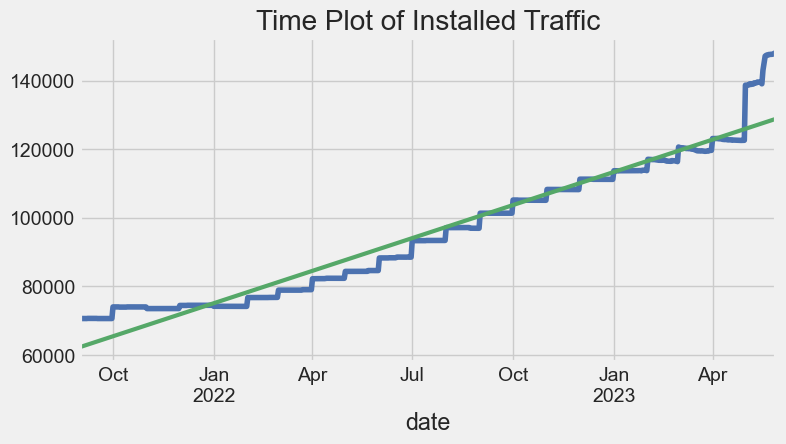

In [17]:
# Training data
X = df.loc[:, ['time']]  # features
y = df.loc[:, 'installed_capacity']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as the training data
y_pred = pd.Series(model.predict(X), index=X.index)

# Plot the Target & Predicted Values
fig, ax = plt.subplots(figsize=(8, 4))
ax = y.plot(color=deep_colors[0])
ax = y_pred.plot(ax=ax, linewidth=3, color=deep_colors[1])
ax.set_title('Time Plot of Installed Capacity');

In [18]:
formula = 'installed_capacity ~ lag_1'
model = smf.ols(formula, data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     installed_capacity   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 3.415e+05
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:19:41   Log-Likelihood:                -5185.4
No. Observations:                 635   AIC:                         1.037e+04
Df Residuals:                     633   BIC:                         1.038e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -203.7774    167.490     -1.217      0.2

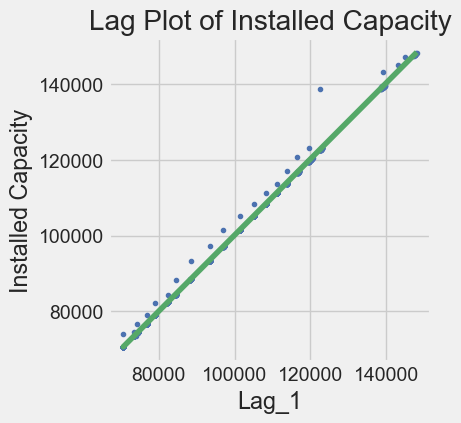

In [19]:
# Training data
X = df.loc[:, ['lag_1']]  # features
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'installed_capacity']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as the training data
y_pred = pd.Series(model.predict(X), index=X.index)

# Plot the Target & Predicted Values
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(X['lag_1'], y, '.', color=deep_colors[0])
ax.plot(X['lag_1'], y_pred, color=deep_colors[1])
ax.set_aspect('equal')
ax.set_ylabel('Installed Capacity')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Installed Capacity');

**Trend**

The *trend* component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance.

To see what kind of trend a time series might have, we can use a *moving average plot*. To compute a moving average of a time series, we compute the average of the values within a sliding window of some defined width. Each point on the graph represents the average of all the values in the series that fall within the window on either side. The idea is to smooth out any short-term fluctuations in the series so that only long-term changes remain. For a change to be a part of the trend, it should occur over a longer period than any seasonal changes. To visualize a trend, therefore, we take an average over a period longer than any seasonal period in the series. Once we've identified the shape of the trend, we can attempt to model it using a time-step feature.

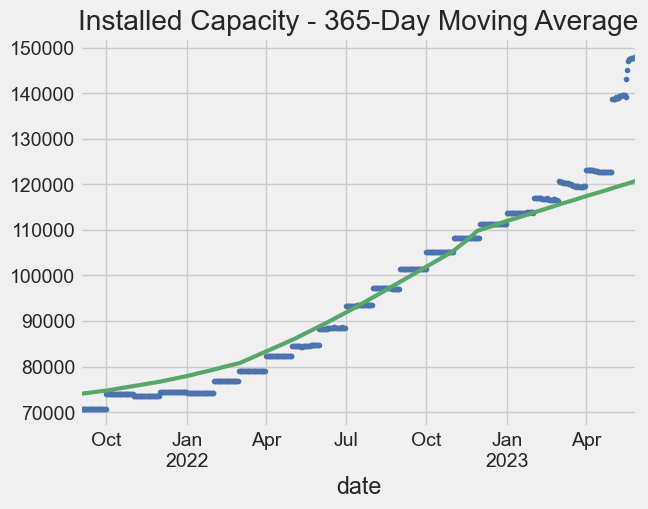

In [20]:
moving_average = df.installed_capacity.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df.installed_capacity.plot(style=".", color=deep_colors[0])
moving_average.plot(
    ax=ax, linewidth=3, title="Installed Capacity - 365-Day Moving Average", legend=False, color=deep_colors[1]
);

Above, we engineered our time dummy in Pandas directly. From now on, however, we'll use a function from the `statsmodels` library called `DeterministicProcess`. Using this function will help us avoid some tricky failure cases that can arise with time series and linear regression. The `order` argument refers to polynomial order: `1` for linear, `2` for quadratic, `3` for cubic, and so on.

A *deterministic process*, by the way, is a technical term for a time series that is non-random or completely *determined*, like the `const` and `trend` series are. Features derived from the time index will generally be deterministic.

We create our trend model basically as before, though note the addition of the `fit_intercept=False` argument.

In [21]:
dp = DeterministicProcess(
    index=df.installed_capacity.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
date,,
2021-09-01,1.0,1.0
2021-09-02,1.0,2.0
2021-09-03,1.0,3.0
2021-09-04,1.0,4.0
2021-09-05,1.0,5.0


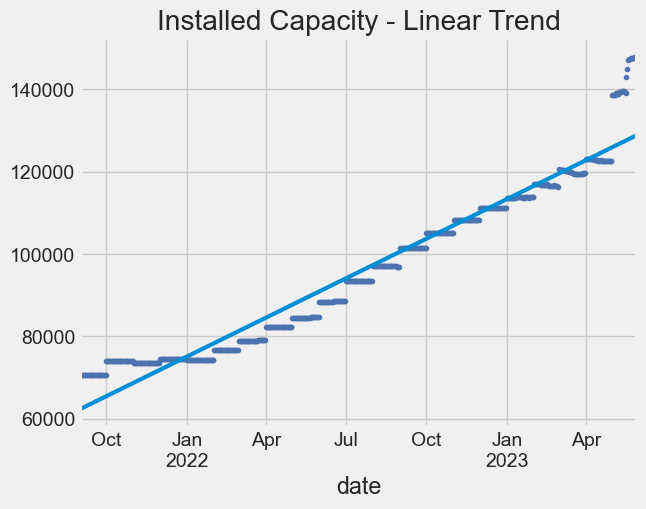

In [22]:
y = df["installed_capacity"]  # the target

# The intercept is the same as the `const` feature from DeterministicProcess. LinearRegression behaves badly with duplicated features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)


ax = df.installed_capacity.plot(style=".", color=deep_colors[0], title="Installed Capacity - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

The trend discovered by our `LinearRegression` model is almost identical to the moving average plot, which suggests that a linear trend was the right decision in this case.

To make a forecast, we apply our model to "out of sample" features. "Out of sample" refers to times outside of the observation period of the training data. Here's how we could make a 30-day forecast:

2023-05-30    129008.721131
2023-05-31    129113.549474
2023-06-01    129218.377817
2023-06-02    129323.206160
2023-06-03    129428.034503
Freq: D, dtype: float64


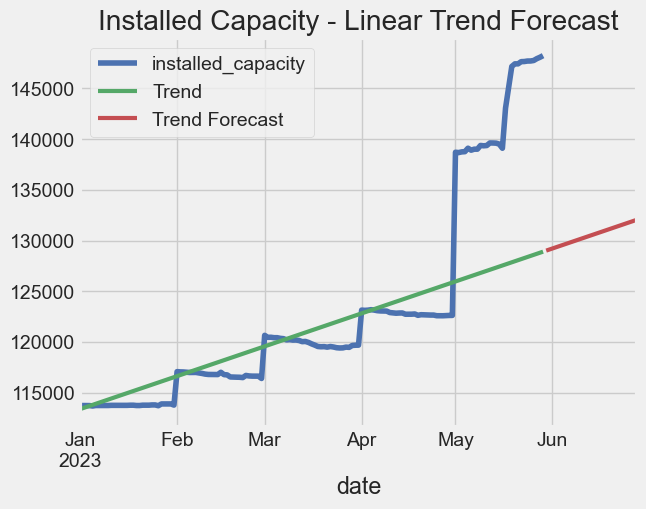

In [23]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)
print(y_fore.head())

ax = df["2023-01":].installed_capacity.plot(title="Installed Capacity - Linear Trend Forecast", color=deep_colors[0])
ax = y_pred["2023-01":].plot(ax=ax, linewidth=3, label="Trend", color=deep_colors[1])
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color=deep_colors[2])
_ = ax.legend()

**Seasonality**

A time series exhibits *seasonality* whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar. Repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times.

There are two kinds of features that model seasonality:
* The first kind, indicators, is best for a season with few observations, like a weekly season of daily observations. 
* The second kind, Fourier features, is best for a season with many observations, like an annual season of daily observations.

Just like we used a moving average plot to discover the trend in a series, we can use a *seasonal plot* to discover seasonal patterns. A seasonal plot shows segments of the time series plotted against some common period, the period being the "season" you want to observe. *Seasonal indicators* are binary features that represent seasonal differences in the level of a time series. Seasonal indicators are what you get if you treat a seasonal period as a categorical feature and apply one-hot encoding. By one-hot encoding days of the week, we get weekly seasonal indicators. Adding seasonal indicators to the training data helps models distinguish means within a seasonal period. The indicators act as On / Off switches. At any time, at most one of these indicators can have a value of `1` (*On*).

**Fourier features** are pairs of sine and cosine curves, one pair for each potential frequency in the season starting with the longest. Fourier pairs modeling annual seasonality would have frequencies: once per year, twice per year, three times per year, and so on. If we add a set of these sine / cosine curves to our training data, the linear regression algorithm will figure out the weights that will fit the seasonal component in the target series. By modeling only the "main effect" of the seasonality with Fourier features, you'll usually need to add far fewer features to your training data, which means reduced computation time and less risk of overfitting.

How many Fourier pairs should we actually include in our feature set? We can answer this question with the periodogram. The **periodogram** tells you the strength of the frequencies in a time series. Specifically, the value on the y-axis of the graph is `(a ** 2 + b ** 2) / 2`, where `a` and `b` are the coefficients of the sine and cosine at that frequency (as in the *Fourier Components* plot above).

In [24]:
# Compute Fourier Features

import numpy as np

def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


# Compute Fourier features to the 4th order (8 new features) for a series y with daily observations and annual seasonality:
fourier_features(y, freq=365.25, order=4).head()

,sin_365.25_1,cos_365.25_1,sin_365.25_2,cos_365.25_2,sin_365.25_3,cos_365.25_3,sin_365.25_4,cos_365.25_4
installed_capacity,,,,,,,,
70659.26,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
70659.26,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669,0.068755,0.997634
70659.26,0.034398,0.999408,0.068755,0.997634,0.103031,0.994678,0.137185,0.990545
70659.26,0.051584,0.998669,0.103031,0.994678,0.154204,0.988039,0.204966,0.978769
70651.26,0.068755,0.997634,0.137185,0.990545,0.204966,0.978769,0.271777,0.962360


Functions to plot seasonal plot and periodogram:

In [25]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

Let's take a look at seasonal plots over a week and over a year:

In [26]:
X = df.installed_capacity.copy().to_frame()
X.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 636 entries, 2021-09-01 to 2023-05-29
Freq: D
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   installed_capacity  636 non-null    float64
dtypes: float64(1)
memory usage: 26.1 KB


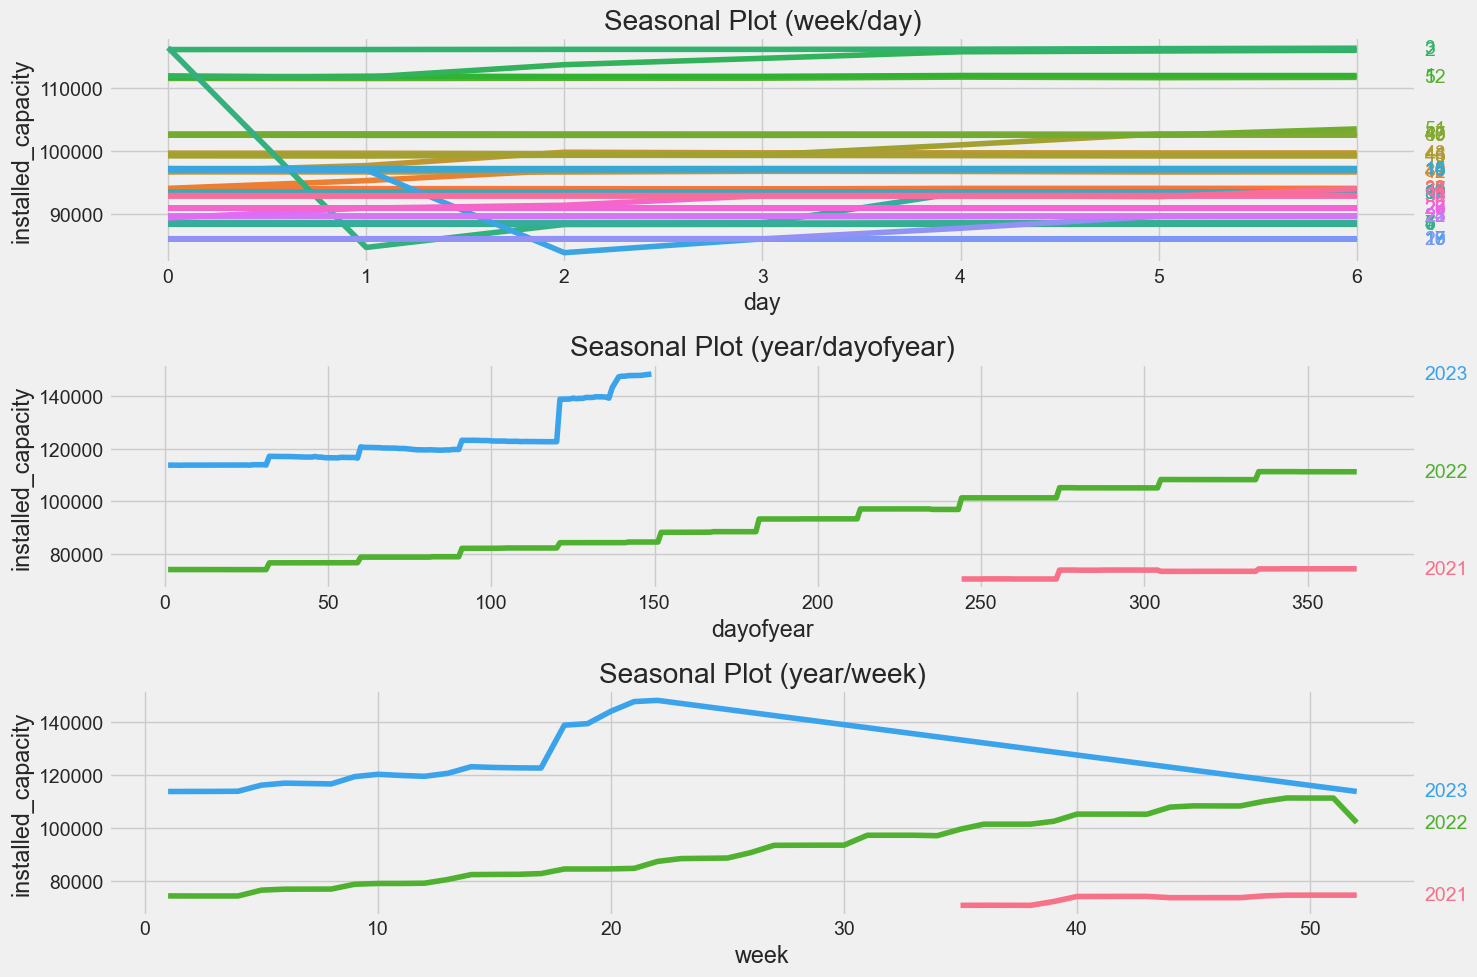

In [27]:
X = df.installed_capacity.copy().to_frame()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(15, 10))
seasonal_plot(X, y="installed_capacity", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="installed_capacity", period="year", freq="dayofyear", ax=ax1)
seasonal_plot(X, y="installed_capacity", period="year", freq="week", ax=ax2)
plt.tight_layout();

Plot periodogram:

At best, installed capacity has an annual seasonal trend. 

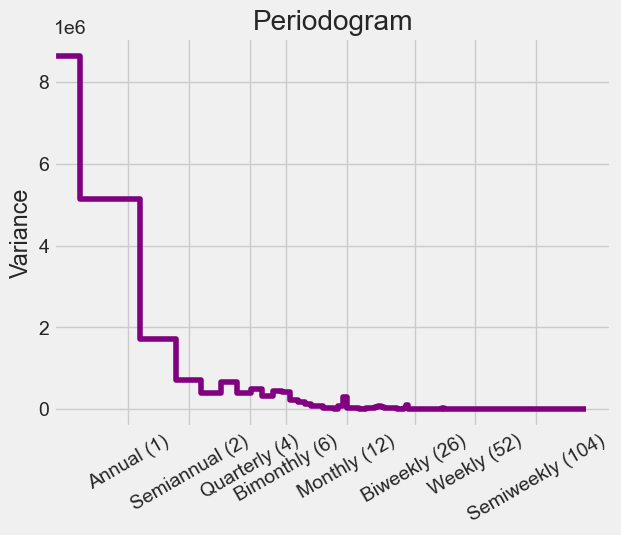

In [28]:
plot_periodogram(df.installed_capacity);

We'll create our seasonal features using `DeterministicProcess`. To use two seasonal periods (weekly and annual), we'll need to instantiate one of them as an "additional term":

In [29]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=df.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

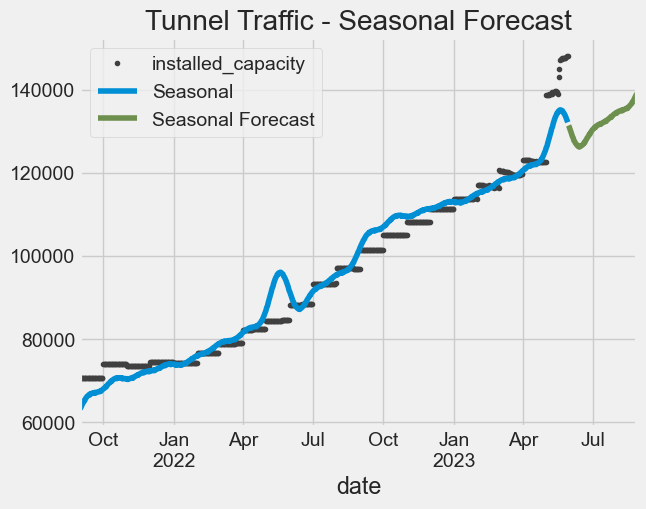

In [30]:

y = df["installed_capacity"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

Removing from a series its trend or seasons is called detrending or deseasonalizing the series.

Look at the periodogram of the deseasonalized series.

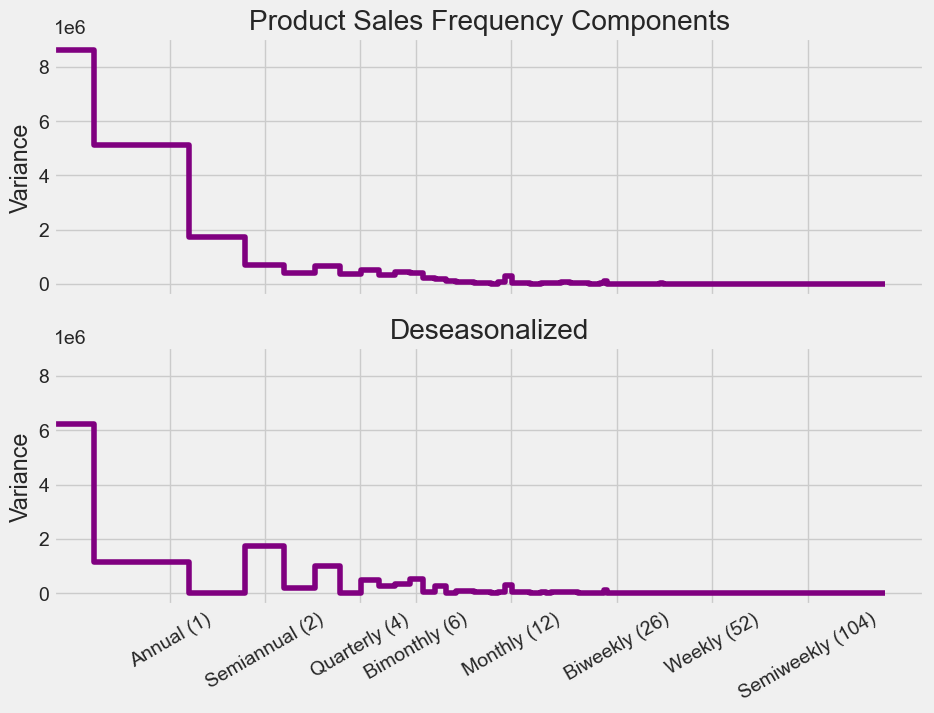

In [31]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

**Time Series as Features**

We've investigated properties of time series that were most easily modeled as *time dependent* properties, that is, with features we could derive directly from the time index (trend and seasonality). Some time series properties, however, can only be modeled as *serially dependent* properties, that is, using as features past values of the target series.

**Cycles**

One especially common way for serial dependence to manifest is in *cycles*. Cycles are patterns of growth and decay in a time series associated with how the value in a series at one time depends on values at previous times, but not necessarily on the time step itself.  Cyclic behavior is characteristic of systems that can affect themselves or whose reactions persist over time.

What distinguishes cyclic behavior from seasonality is that cycles are not necessarily time dependent, as seasons are. What happens in a cycle is less about the particular date of occurrence, and more about what has happened in the recent past. The (at least relative) independence from time means that cyclic behavior can be much more irregular than seasonality.

**Lagged Series and Lag Plots**

To investigate possible serial dependence (like cycles) in a time series, we need to create "lagged" copies of the series. *Lagging* a time series means to shift its values forward one or more time steps, or equivalently, to shift the times in its index backward one or more steps. In either case, the effect is that the observations in the lagged series will appear to have happened later in time.

By lagging a time series, we can make its past values appear contemporaneous with the values we are trying to predict (in the same row, in other words). This makes lagged series useful as features for modeling serial dependence.

A *lag plot* of a time series shows its values plotted against its lags. Serial dependence in a time series will often become apparent by looking at a lag plot. The most commonly used measure of serial dependence is known as *autocorrelation*, which is simply the correlation a time series has with one of its lags.

**Choosing lags**

When choosing lags to use as features, it generally won't be useful to include *every* lag with a large autocorrelation. The *partial autocorrelation* tells you the correlation of a lag accounting for all of the previous lags -- the amount of "new" correlation the lag contributes, so to speak. Plotting the partial autocorrelation can help you choose which lag features to use. The correlogram is for lag features essentially what the periodogram is for Fourier features.

Finally, we need to be mindful that autocorrelation and partial autocorrelation are measures of *linear* dependence. Because real-world time series often have substantial non-linear dependencies, it's best to look at a lag plot (or use some more general measure of dependence when choosing lag features. Non-linear relationships like these can either be transformed to be linear or else learned by an appropriate algorithm.

In [32]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

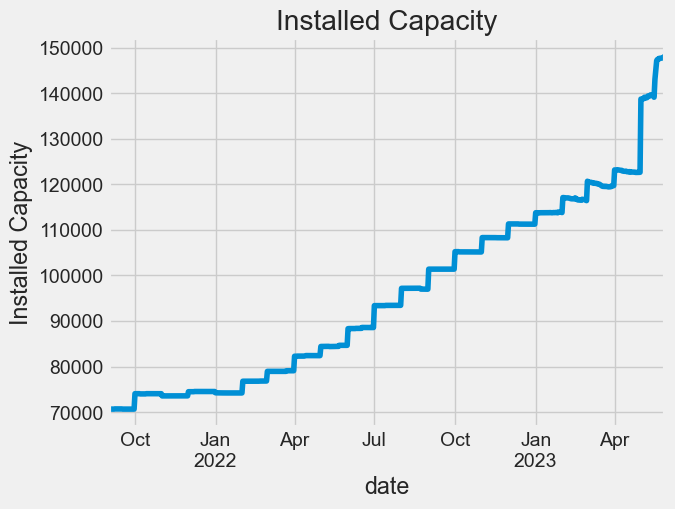

In [36]:
ax = df.installed_capacity.plot(title='Installed Capacity',)
_ = ax.set(ylabel="Installed Capacity")

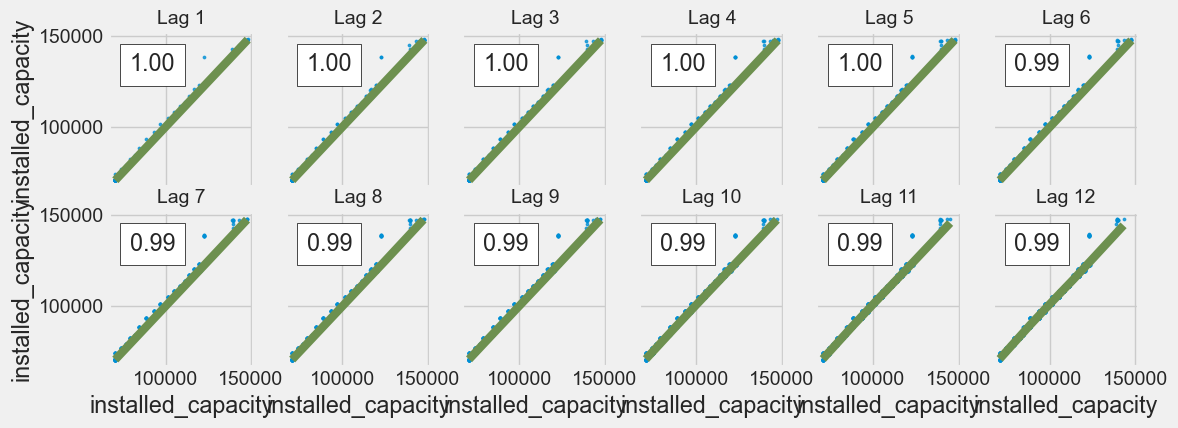

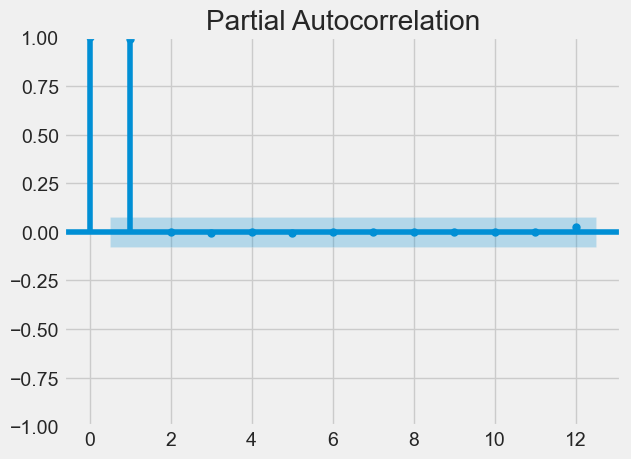

In [37]:
_ = plot_lags(df.installed_capacity, lags=12, nrows=2)
_ = plot_pacf(df.installed_capacity, lags=12)

The lag plots indicate that the relationship of `installed_capacity` to its lags is mostly linear, while the partial autocorrelations suggest the dependence can be captured using lag 1. We can lag a time series in Pandas with the `shift` method. For this problem, we'll fill in the missing values the lagging creates with `0.0`

In [38]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(df.installed_capacity, lags=4)
X = X.fillna(0.0)

When using lag features, however, we are limited to forecasting time steps whose lagged values are available. Using a lag 1 feature on Monday, we can't make a forecast for Wednesday because the lag 1 value needed is Tuesday which hasn't happened yet.

In [40]:
# Create target series and data splits
y = df.installed_capacity.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

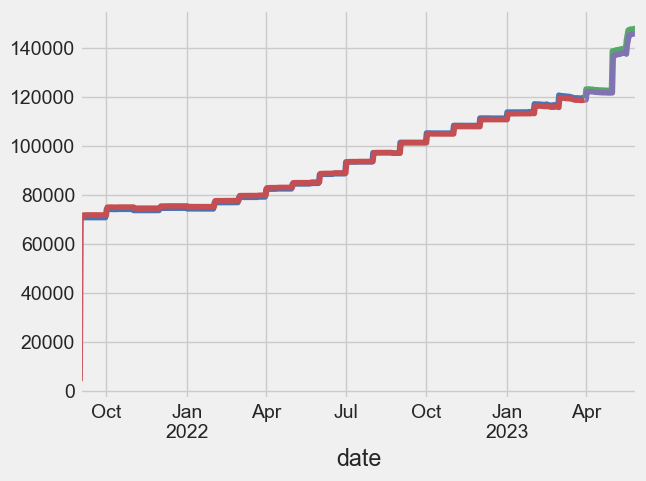

In [43]:
ax = y_train.plot(color=deep_colors[0])
ax = y_test.plot(color=deep_colors[1])
ax = y_pred.plot(ax=ax, color=deep_colors[2])
_ = y_fore.plot(ax=ax, color=deep_colors[3])

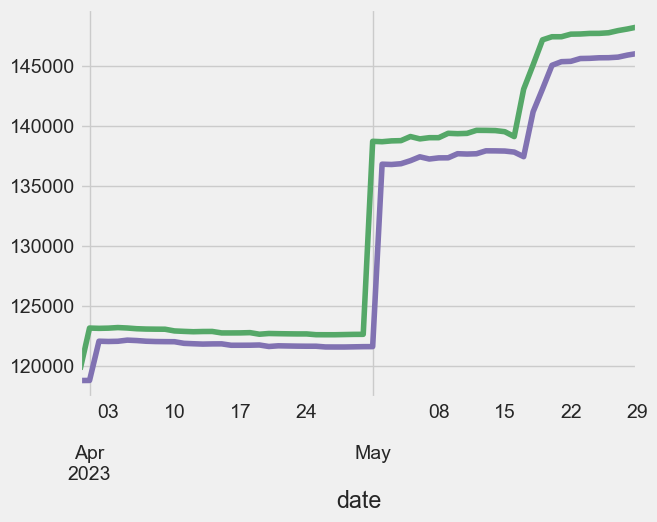

In [44]:
ax = y_test.plot(color=deep_colors[1])
_ = y_fore.plot(ax=ax, color=deep_colors[3])

To improve the forecast we could try to find *leading indicators*, time series that could provide an "early warning" for changes in installed capacity. A leading indicator is a series whose values at one time can be used to predict the target at a future time—a leading indicator provides "advance notice" of changes in the target. We'll use consumption points as a leading indicator.

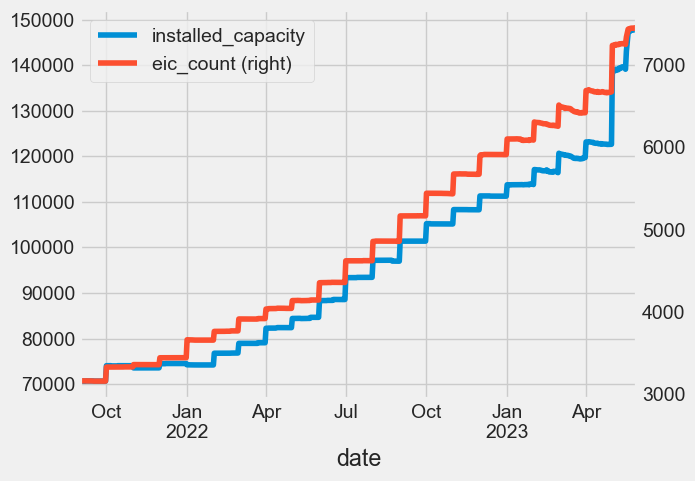

In [46]:
ax = enefit_dict['client'].set_index("date")[['installed_capacity', 'eic_count']].resample('D').sum().to_period().plot(
    y=["installed_capacity", "eic_count"],
    secondary_y="eic_count",
)

In [47]:
df = enefit_dict['client'].set_index("date")[['installed_capacity', 'eic_count']].resample('D').sum().to_period()

X0 = make_lags(df['eic_count'], lags=3)

# Create four lags for the target, as before
X1 = make_lags(df['installed_capacity'], lags=4)

# Combine to create the training data
X = pd.concat([X0, X1], axis=1).fillna(0.0)

X.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_1,y_lag_2,y_lag_3,y_lag_4
date,,,,,,,
2021-09-01,0.0,0.0,0.0,0.00,0.00,0.00,0.00
2021-09-02,3159.0,0.0,0.0,70659.26,0.00,0.00,0.00
2021-09-03,3159.0,3159.0,0.0,70659.26,70659.26,0.00,0.00
2021-09-04,3159.0,3159.0,3159.0,70659.26,70659.26,70659.26,0.00
2021-09-05,3159.0,3159.0,3159.0,70659.26,70659.26,70659.26,70659.26


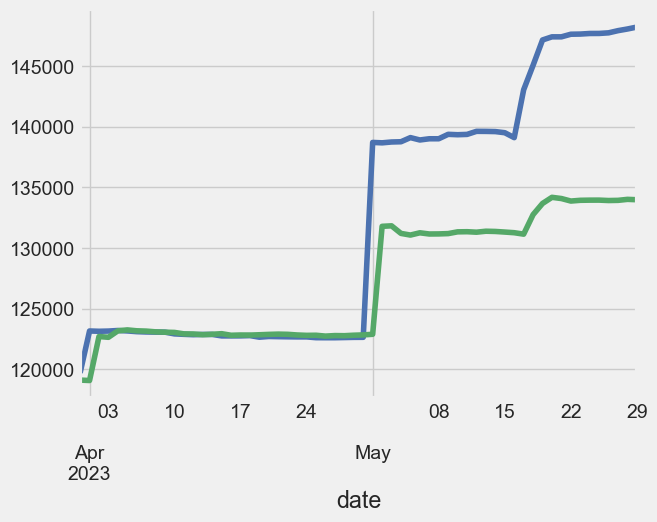

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(color=deep_colors[0])
_ = y_fore.plot(ax=ax, color=deep_colors[1])

It's not uncommon though for time series to possess trend, seasonality, and cycles—all three components at once. You could model such series with linear regression by just adding the appropriate features for each component. You can even combine models trained to learn the components separately, which we'll learn how to do in the next lesson with *forecasting hybrids*.

**Forecasting with ML**

We've treated forecasting as a simple regression problem with all of our features derived from a single input, the time index. We could easily create forecasts for any time in the future by just generating our desired trend and seasonal features. When we added lag features, however, the nature of the problem changed. Lag features require that the lagged target value is known at the time being forecast. A lag 1 feature shifts the time series forward 1 step, which means you could forecast 1 step into the future but not 2 steps.

We just assumed that we could always generate lags up to the period we wanted to forecast (every prediction was for just one step forward, in other words). Real-world forecasting typically demands more than this, so in this lesson we'll learn how to make forecasts for a variety of situations.

**Defining the Forecasting Task**

There are two things to establish before designing a forecasting model:
- what information is available at the time a forecast is made (features), and,
- the time period during which you require forecasted values (target).

The *forecast origin* is time at which you are making a forecast. Practically, you might consider the forecast origin to be the last time for which you have training data for the time being predicted. Everything up to he origin can be used to create features.

The *forecast horizon* is the time for which you are making a forecast. We often describe a forecast by the number of time steps in its horizon: a "1-step" forecast or "5-step" forecast, say. The forecast horizon describes the target.

The time between the origin and the horizon is the *lead time* (or sometimes *latency*) of the forecast. A forecast's lead time is described by the number of steps from origin to horizon: a "1-step ahead" or "3-step ahead" forecast, say. In practice, it may be necessary for a forecast to begin multiple steps ahead of the origin because of delays in data acquisition or processing.

**Preparing Data for Forecasting**

To forecast time series with ML algorithms, we need to transform the series into a dataframe we can use with those algorithms. (Unless you are only using deterministic features like trend and seasonality). We saw the first half of this process when we created a feature set out of lags. The second half is preparing the target. How we do this depends on the forecasting task.

Each row in a dataframe represents a single forecast. The time index of the row is the first time in the forecast horizon, but we arrange values for the entire horizon in the same row. For multistep forecasts, this means we are requiring a model to produce multiple outputs, one for each step.

**Multistep Forecasting Strategies**

There are a number of strategies for producing the multiple target steps required for a forecast. We'll outline four common strategies, each with strengths and weaknesses:
- Multioutput model: Use a model that produces multiple outputs naturally. Linear regression and neural networks can both produce multiple outputs. This strategy is simple and efficient, but not possible for every algorithm you might want to use. XGBoost can't do this, for instance.
- Direct strategy: Train a separate model for each step in the horizon: one model forecasts 1-step ahead, another 2-steps ahead, and so on. Forecasting 1-step ahead is a different problem than 2-steps ahead (and so on), so it can help to have a different model make forecasts for each step. The downside is that training lots of models can be computationally expensive.
- Recursive strategy: Train a single one-step model and use its forecasts to update the lag features for the next step. With the recursive method, we feed a model's 1-step forecast back in to that same model to use as a lag feature for the next forecasting step. We only need to train one model, but since errors will propagate from step to step, forecasts can be inaccurate for long horizons.
- DirRec strategy: A combination of the direct and recursive strategies: train a model for each step and use forecasts from previous steps as *new* lag features. Step by step, each model gets an additional lag input. Since each model always has an up-to-date set of lag features, the DirRec strategy can capture serial dependence better than Direct, but it can also suffer from error propagation like Recursive.

In this example we'll apply the MultiOutput and Direct strategies to the *Installed Capacity* data, this time making true forecasts for multiple weeks beyond the training period. We'll define our forecasting task to have an 8-day horizon with a 1-day lead time. In other words, we'll be forecasting eight weeks of flu cases starting with the following week.

First we'll prepare our target series (daily installed capacity) for multistep forecasting. Once this is done, training and prediction will be very straightfoward.

In [53]:
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# Four weeks of lag features
y = df.installed_capacity.copy()
X = make_lags(y, lags=4).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=8).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

**Multioutput model**

We'll use linear regression as a MultiOutput strategy. Once we have our data prepared for multiple outputs, training and prediction is the same as always.

In [54]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Remember that a multistep model will produce a complete forecast for each instance used as input.

Train RMSE: 3291.05
Test RMSE: 4125.85


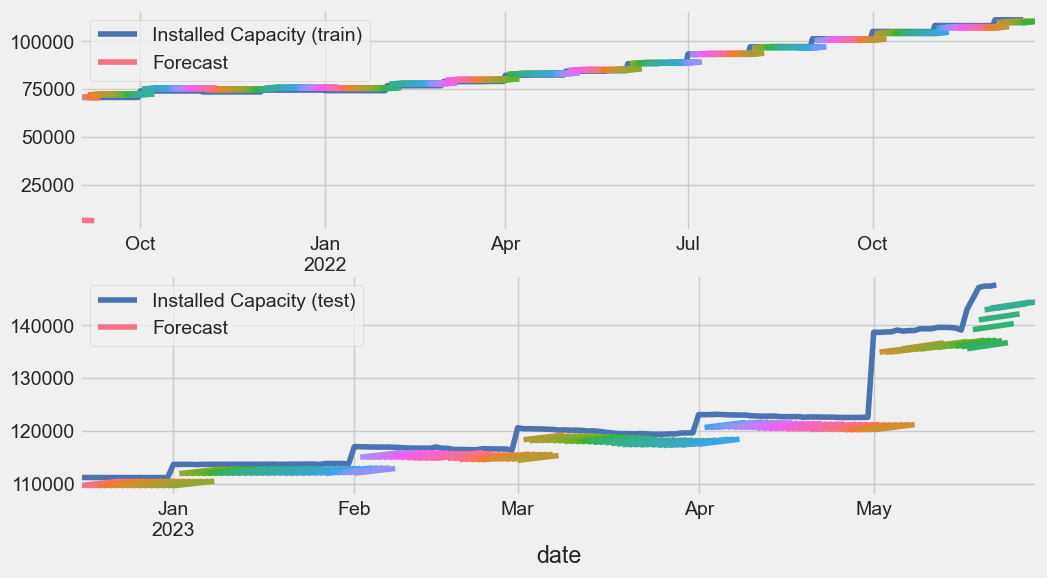

In [57]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = df.installed_capacity[y_fit.index].plot(color=deep_colors[0], ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Installed Capacity (train)', 'Forecast'])
ax2 = df.installed_capacity[y_pred.index].plot(color=deep_colors[0], ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Installed Capacity (test)', 'Forecast'])

To use the DirRec strategy, you would only need to replace `MultiOutputRegressor` with another scikit-learn wrapper, `RegressorChain`.

**Hybrid Models**

Linear regression excels at extrapolating trends, but can't learn interactions. XGBoost excels at learning interactions, but can't extrapolate trends. We'll create "hybrid" forecasters that combine complementary learning algorithms and let the strengths of one make up for the weakness of the other. 

**Components and Residuals**

So that we can design effective hybrids, we need a better understanding of how time series are constructed. We've already seen three patterns of dependence: trend, seasons, and cycles. Many time series can be closely described by an additive model of just these three components plus some essentially unpredictable, entirely random *error*:

```
series = trend + seasons + cycles + error
```

Each of the terms in this model we would then call a **component** of the time series.

The *residuals* of a model are the difference between the target the model was trained on and the predictions the model makes -- the difference between the actual curve and the fitted curve, in other words. Plot the residuals against a feature, and you get the "left over" part of the target, or what the model failed to learn about the target from that feature.

Add together all the components we learned and we get the complete model. This is essentially what linear regression would do if you trained it on a complete set of features modeling trend, seasons, and cycles.

**Hybrid Forecasting with Residuals**

It's possible to use one algorithm for some components and another algorithm for the rest. This way we can always choose the best algorithm for each component. To do this, we use one algorithm to fit the original series and then the second algorithm to fit the residual series.

In detail, the process is this:
```
# 1. Train and predict with first model
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)

# 2. Train and predict with second model on residuals
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)

# 3. Add to get overall predictions
y_pred = y_pred_1 + y_pred_2
```

We'll usually want to use different feature sets (`X_train_1` and `X_train_2` above) depending on what we want each model to learn. If we use the first model to learn the trend, we generally wouldn't need a trend feature for the second model, for example.

While it's possible to use more than two models, in practice it doesn't seem to be especially helpful. In fact, the most common strategy for constructing hybrids is the one we've just described: a simple (usually linear) learning algorithm followed by a complex, non-linear learner like GBDTs or a deep neural net, the simple model typically designed as a "helper" for the powerful algorithm that follows.

**Designing Hybrids**

There are many ways you could combine machine learning models besides the way we've outlined in this lesson. Successfully combining models, though, requires that we dig a bit deeper into how these algorithms operate.

There are generally two ways a regression algorithm can make predictions: either by transforming the *features* or by transforming the *target*. 
- Feature-transforming algorithms learn some mathematical function that takes features as an input and then combines and transforms them to produce an output that matches the target values in the training set. Linear regression and neural nets are of this kind.
- Target-transforming algorithms use the features to group the target values in the training set and make predictions by averaging values in a group; a set of features just indicates which group to average. Decision trees and nearest neighbors are of this kind.

The important thing is this: feature transformers generally can *extrapolate* target values beyond the training set given appropriate features as inputs, but the predictions of target transformers will always be bound within the range of the training set. If the time dummy continues counting time steps, linear regression continues drawing the trend line. Given the same time dummy, a decision tree will predict the trend indicated by the last step of the training data into the future forever. *Decision trees cannot extrapolate trends.* Random forests and gradient boosted decision trees (like XGBoost) are ensembles of decision trees, so they also cannot extrapolate trends.

This difference is what motivates the hybrid design: use linear regression to extrapolate the trend, transform the *target* to remove the trend, and apply XGBoost to the detrended residuals. To hybridize a neural net (a feature transformer), you could instead include the predictions of another model as a feature, which the neural net would then include as part of its own predictions. The method of fitting to residuals is actually the same method the gradient boosting algorithm uses, so we will call these **boosted** hybrids; the method of using predictions as features is known as "stacking", so we will call these **stacked** hybrids.

First, let's use a linear regression model to learn the trend in each (installed capacity & eic count) series. For demonstration, we'll use a quadratic (order 2) trend. Though the fit isn't perfect, it will be enough for our needs.

In [58]:
df.head()

,installed_capacity,eic_count
date,,
2021-09-01,70659.26,3159
2021-09-02,70659.26,3159
2021-09-03,70659.26,3159
2021-09-04,70659.26,3159
2021-09-05,70651.26,3158


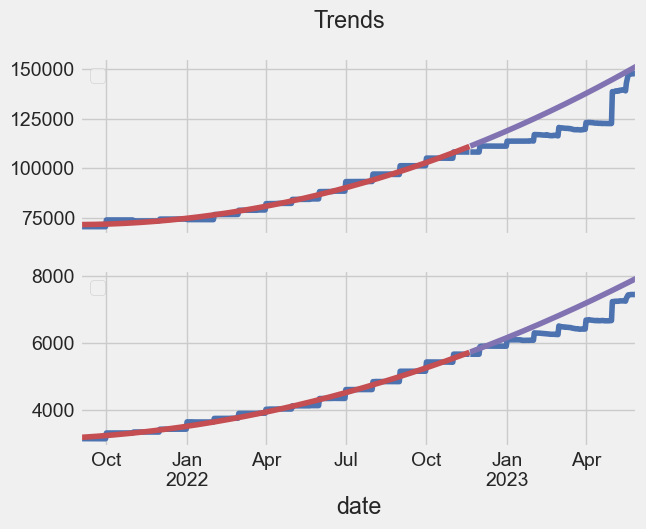

In [69]:

y = df.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=.3, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color=deep_colors[0], subplots=True)
axs = y_test.plot(color=deep_colors[0], subplots=True, ax=axs)
axs = y_fit.plot(color=deep_colors[2], subplots=True, ax=axs)
axs = y_pred.plot(color=deep_colors[3], subplots=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

While the linear regression algorithm is capable of multi-output regression, the XGBoost algorithm is not. To predict multiple series at once with XGBoost, we'll instead convert these series from *wide* format, with one time series per column, to *long* format, with series indexed by categories along rows.

In [104]:
# The `stack` method converts column labels to row labels, pivoting from wide format to long
X = df.stack()
X.index = X.index.set_names(['date', 'value_id'])
X.name = 'value'
y = X

So that XGBoost can learn to distinguish our two time series, we'll turn the row labels for `'value_id'` into a categorical feature with a label encoding. We'll also create a feature for annual seasonality by pulling the month numbers out of the time index.

In [105]:
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('value_id')
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["Month"] = X.index.month

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

Now we'll convert the trend predictions made earlier to long format and then subtract them from the original series. That will give us detrended (residual) series that XGBoost can learn.

In [114]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
# y_fit = y_fit.stack().squeeze()    # trend from training set
# y_pred = y_pred.stack().squeeze()  # trend from test set
y_fit.index = y_fit.index.set_names(['date', 'value_id'])
y_pred.index = y_pred.index.set_names(['date', 'value_id'])

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versio

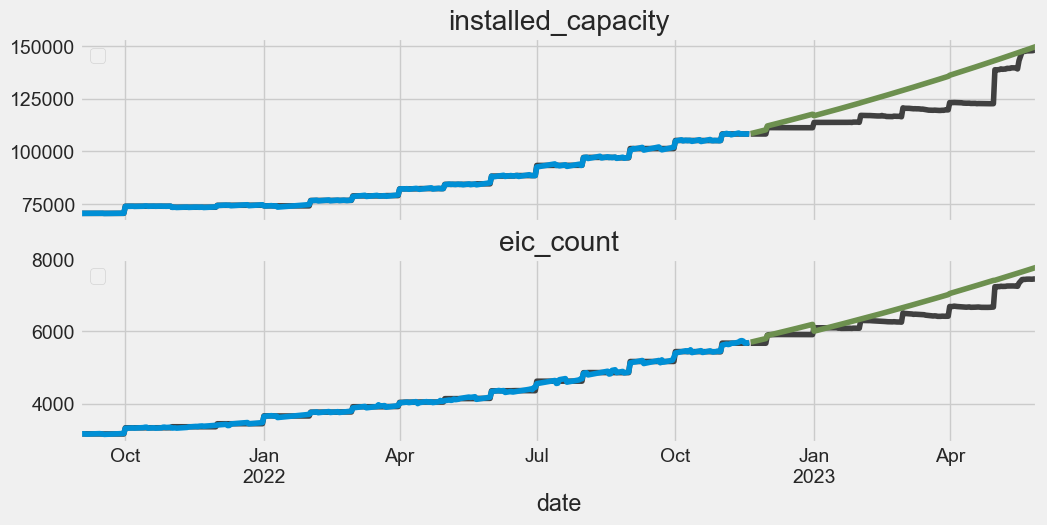

In [116]:
axs = y_train.unstack(['value_id']).plot(
    color='0.25', figsize=(11, 5), subplots=True,
    title=['installed_capacity', 'eic_count'],
)
axs = y_test.unstack(['value_id']).plot(
    color='0.25', subplots=True, ax=axs,
)
axs = y_fit_boosted.unstack(['value_id']).plot(
    color='C0', subplots=True, ax=axs,
)
axs = y_pred_boosted.unstack(['value_id']).plot(
    color='C3', subplots=True, ax=axs,
)
for ax in axs: ax.legend([])